# Reference GNN Model From Various Sources

In [1]:
from torch_geometric.datasets import MoleculeNet

dataset = MoleculeNet(".",name="ESOL")


/Users/ashi/Desktop/SOLGNN/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch.nn import Linear 
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gp , global_max_pool as gmp

torch.manual_seed(1011)    
EMBEDDING_DIMENSION = 64

class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN,self).__init__()
    self.initial_conv = GCNConv(
      in_channels=dataset.num_features,
      out_channels=EMBEDDING_DIMENSION,
    )
    self.conv1 = GCNConv(EMBEDDING_DIMENSION, EMBEDDING_DIMENSION)
    self.conv2 = GCNConv(EMBEDDING_DIMENSION, EMBEDDING_DIMENSION)
    self.conv3 = GCNConv(EMBEDDING_DIMENSION, EMBEDDING_DIMENSION)

    self.out = Linear(
      in_features=EMBEDDING_DIMENSION * 2,
      out_features=1
    )

  def forward(self, x, edge_index,batch_index):

    hidden = self.initial_conv(x,edge_index)
    hidden = F.tanh(hidden)

    hidden = self.conv1(hidden,edge_index)
    hidden = F.tanh(hidden)

    hidden = self.conv2(hidden,edge_index)
    hidden = F.tanh(hidden)

    hidden = self.conv3(hidden,edge_index)
    hidden = F.tanh(hidden)


    hidden = torch.cat([gmp(hidden,batch_index),gp(hidden,batch_index)],dim=1)



    out = self.out(hidden)

    return out,hidden 
  

REF_MODEL = GCN()
print(REF_MODEL)
print("Number of parameters: ",sum(p.numel() for p in REF_MODEL.parameters()))






GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [3]:
import torch
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
import warnings

warnings.filterwarnings("ignore")

# --- Dataset Loading and Splitting ---
dataset = MoleculeNet(".", name="ESOL")

# Shuffle dataset
torch.manual_seed(1011)
dataset = dataset.shuffle()

# Calculate split sizes
total_count = len(dataset)
train_count = int(0.8 * total_count)
val_count = int(0.1 * total_count)
test_count = total_count - train_count - val_count

# Perform the split
train_dataset = dataset[:train_count]
val_dataset = dataset[train_count:train_count + val_count]
test_dataset = dataset[train_count + val_count:]

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# --- Model Setup ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using APPLE MPS")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")
REF_MODEL = REF_MODEL.to(DEVICE)


# --- Training Configuration ---
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(REF_MODEL.parameters(), lr=0.00025)

# --- DataLoaders ---
NUM_GRAPHS_PER_BATCH = 64
train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

# --- Training Functions ---
def train(loader):
    REF_MODEL.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()

        pred, embedding = REF_MODEL(batch.x.float(), batch.edge_index, batch.batch)
        loss = loss_fn(pred, batch.y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(loader):
    REF_MODEL.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            pred, embedding = REF_MODEL(batch.x.float(), batch.edge_index, batch.batch)
            loss = loss_fn(pred, batch.y)
            total_loss += loss.item()

    return total_loss / len(loader)


# --- Training Loop ---
print("\nStarting training...")
train_losses = []
val_losses = []
test_losses = []
best_val_loss = float('inf')

EPOCHS = 150

for epoch in range(EPOCHS):
    train_loss = train(train_loader)
    val_loss = evaluate(val_loader)
    test_loss = evaluate(test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(REF_MODEL.state_dict(), 'best_gcn_model.pt')

    current_lr = optimizer.param_groups[0]['lr']

    if epoch % 10 == 0:
        print(f"Epoch {epoch:4d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")

print("\nTraining completed!")


Train: 902, Val: 112, Test: 114
Using APPLE MPS

Starting training...
Epoch    0 | Train Loss: 10.5679 | Val Loss: 7.2288 | Test Loss: 8.8154
Epoch   10 | Train Loss: 4.3156 | Val Loss: 4.0389 | Test Loss: 4.9632
Epoch   20 | Train Loss: 4.0124 | Val Loss: 3.6306 | Test Loss: 4.7476
Epoch   30 | Train Loss: 3.8030 | Val Loss: 3.3574 | Test Loss: 4.4484
Epoch   40 | Train Loss: 3.5434 | Val Loss: 3.2606 | Test Loss: 4.1178
Epoch   50 | Train Loss: 3.2443 | Val Loss: 2.8447 | Test Loss: 3.5334
Epoch   60 | Train Loss: 2.8461 | Val Loss: 2.3431 | Test Loss: 2.8727
Epoch   70 | Train Loss: 2.3761 | Val Loss: 2.2695 | Test Loss: 2.5770
Epoch   80 | Train Loss: 2.2920 | Val Loss: 1.6695 | Test Loss: 2.0097
Epoch   90 | Train Loss: 1.9087 | Val Loss: 1.5006 | Test Loss: 1.7326
Epoch  100 | Train Loss: 1.9038 | Val Loss: 1.4722 | Test Loss: 1.6922
Epoch  110 | Train Loss: 1.6560 | Val Loss: 1.3370 | Test Loss: 1.4765
Epoch  120 | Train Loss: 1.7317 | Val Loss: 1.4066 | Test Loss: 1.6043
Epoch 

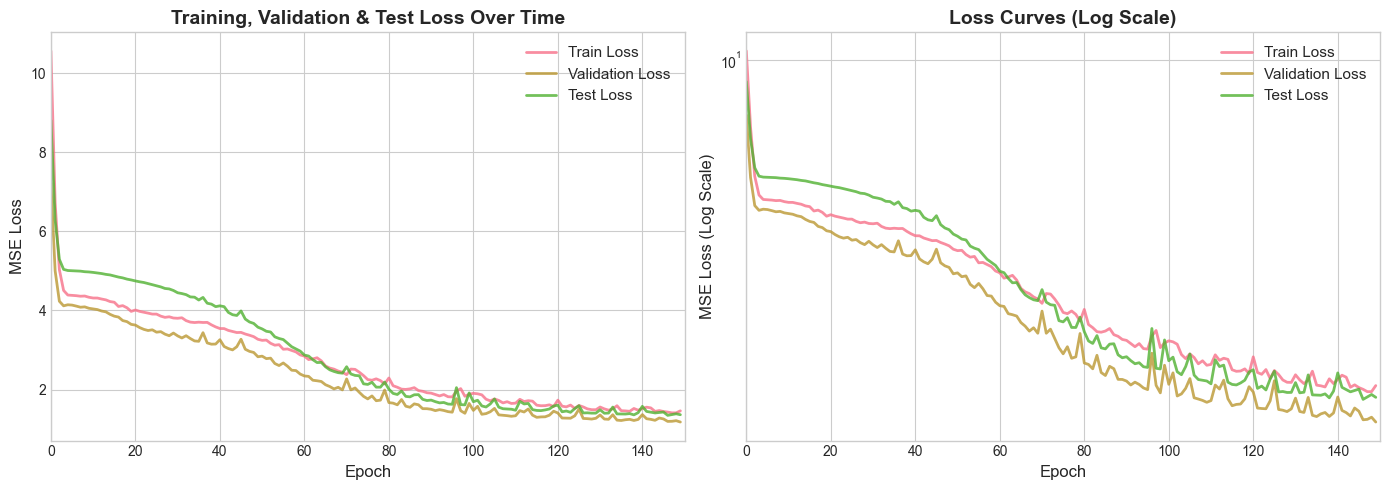

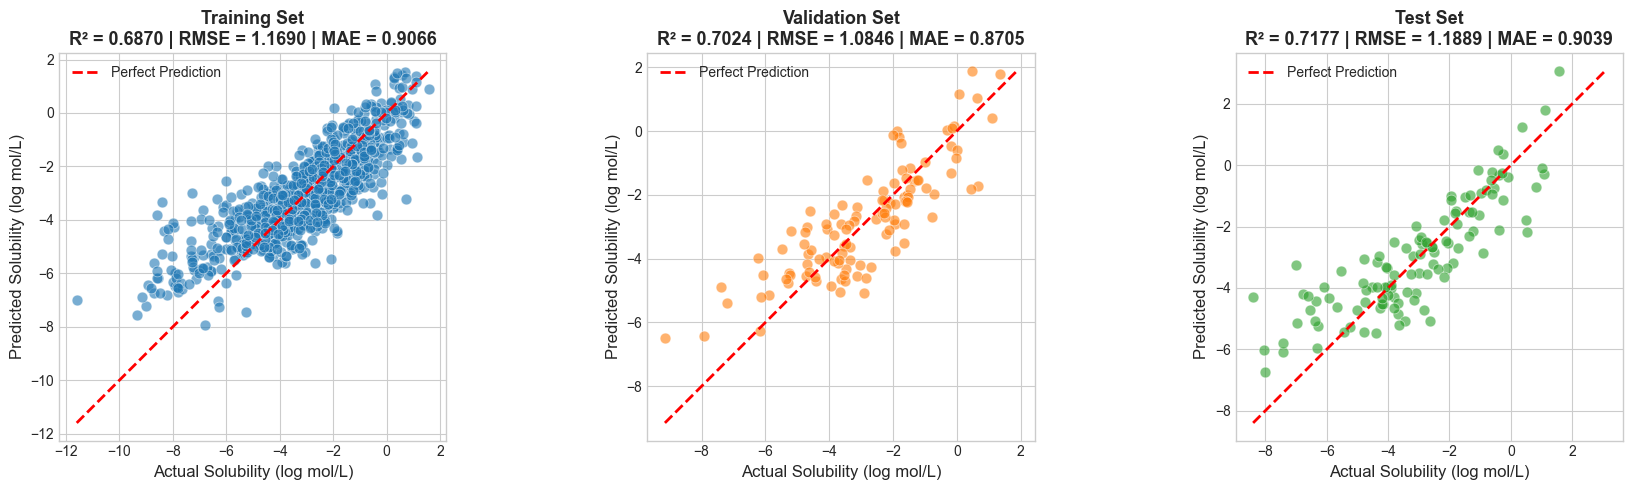

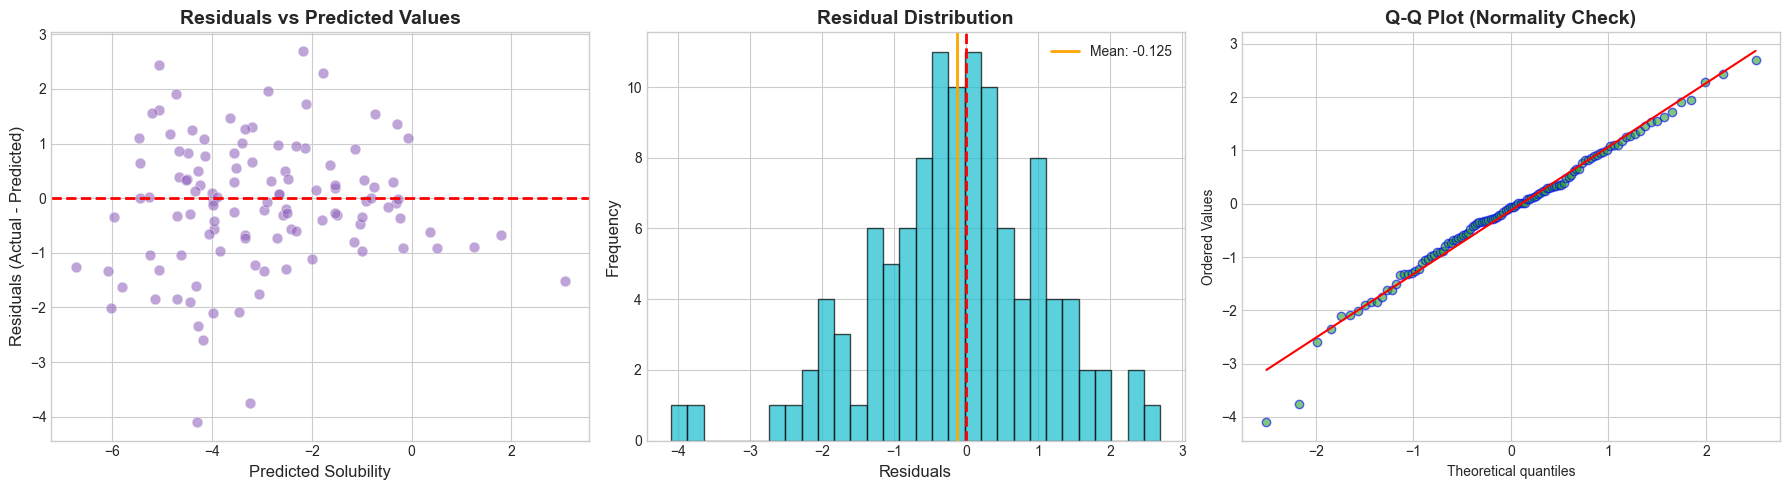


RESIDUAL STATISTICS (Test Set)
Mean Residual: -0.1248
Std Residual:  1.1823
Min Residual:  -4.0943
Max Residual:  2.6950


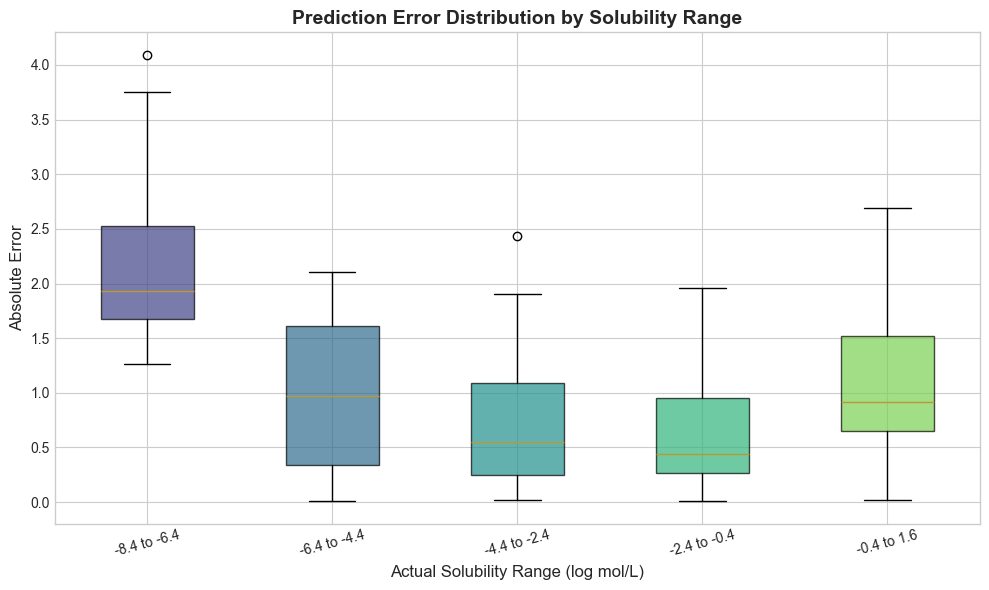


Computing t-SNE embeddings...


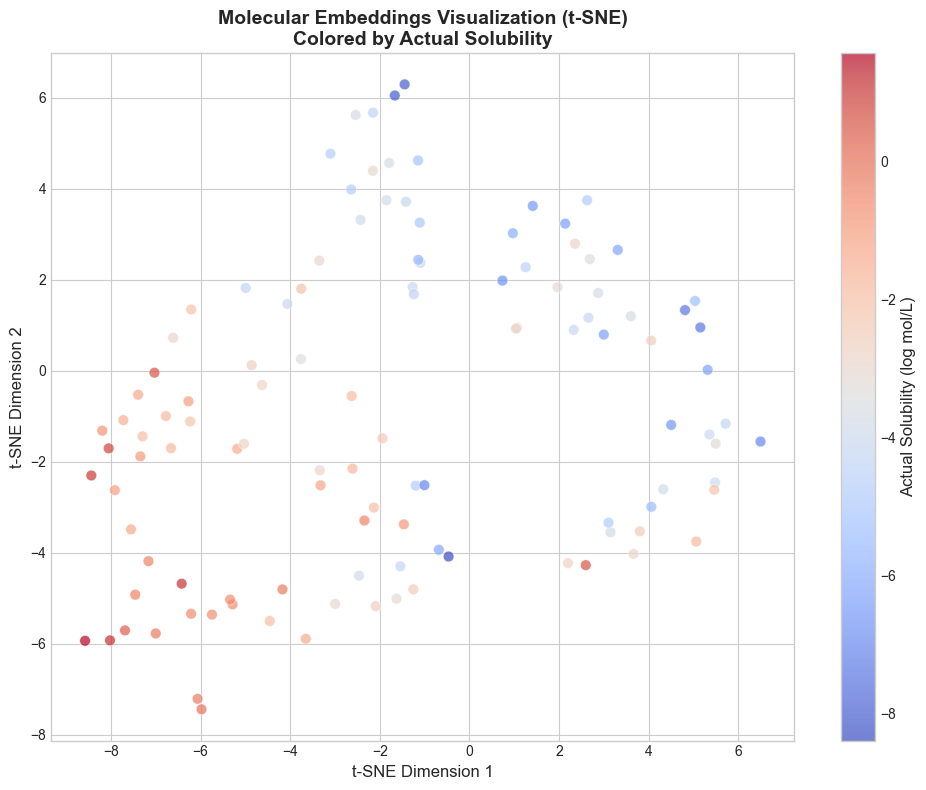

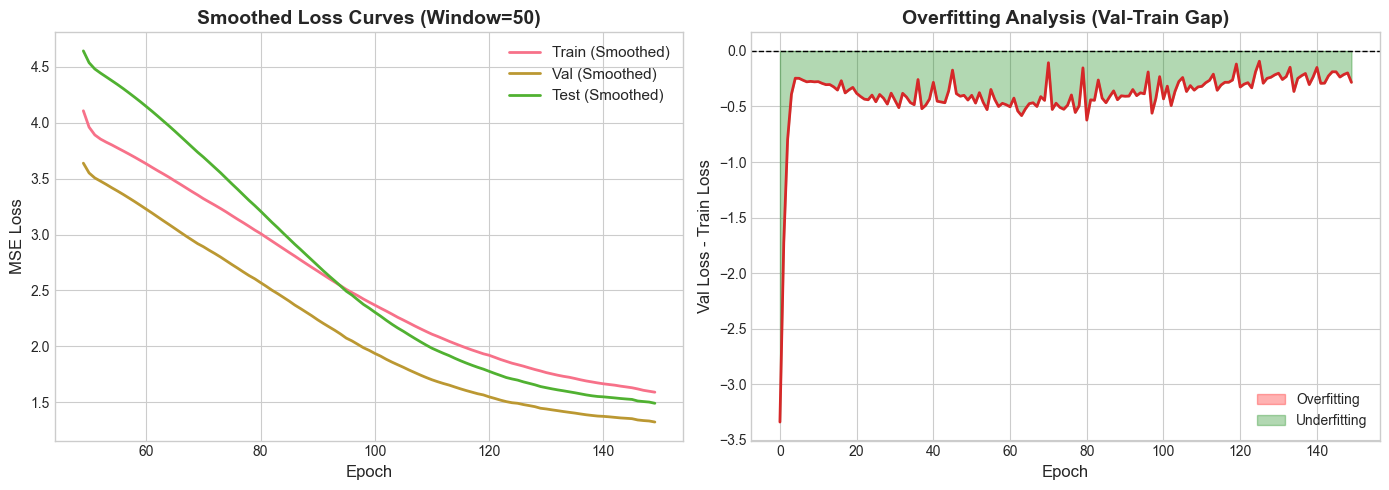


               SIMPLE GCN MODEL PERFORMANCE SUMMARY

Dataset                MSE       RMSE        MAE         R²
-------------------------------------------------------
Train               1.3666     1.1690     0.9066     0.6870
Validation          1.1763     1.0846     0.8705     0.7024
Test                1.4134     1.1889     0.9039     0.7177


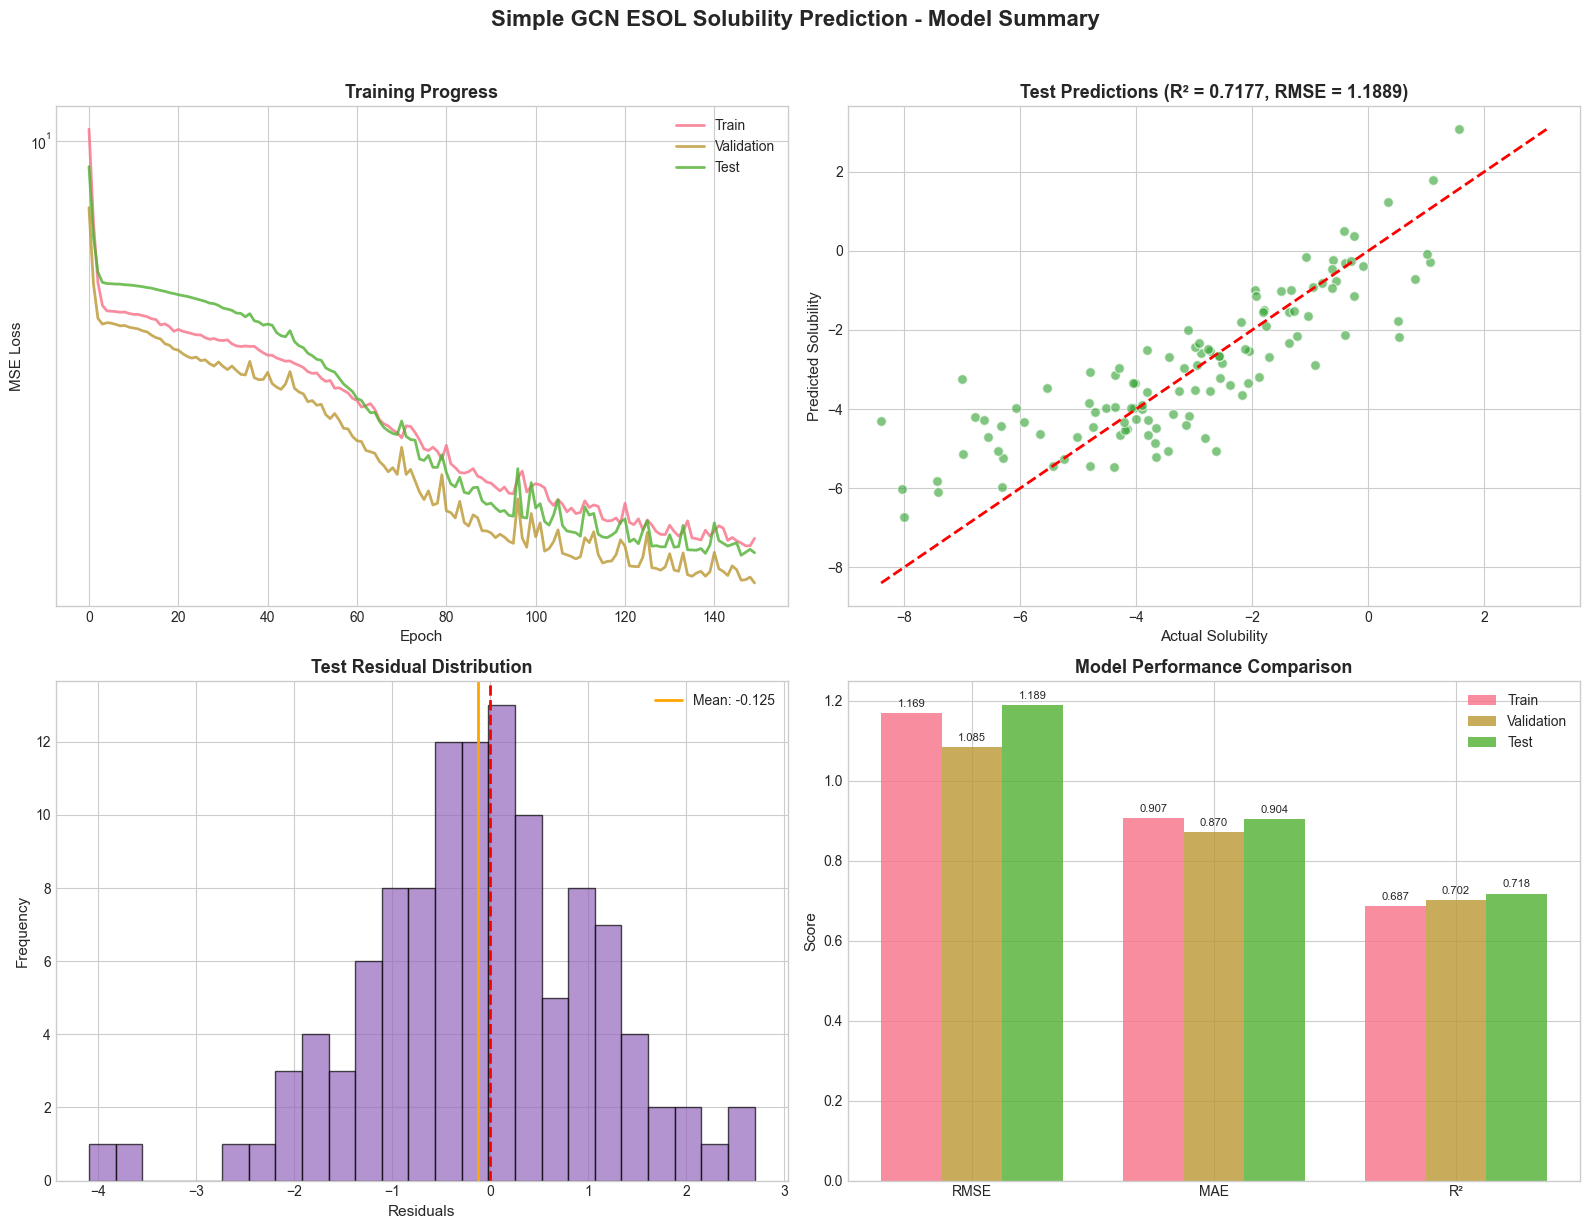


               MODEL ARCHITECTURE SUMMARY

Model: Simple GCN (4-layer Graph Convolutional Network)
Embedding Dimension: 64
Activation Function: Tanh
Pooling: Global Max + Global Mean (Concatenated)
Output: Single regression value

------------------------------------------------------------
Layer-wise Parameters:
------------------------------------------------------------
initial_conv.bias                        [64]                         64
initial_conv.lin.weight                  [64, 9]                     576
conv1.bias                               [64]                         64
conv1.lin.weight                         [64, 64]                   4096
conv2.bias                               [64]                         64
conv2.lin.weight                         [64, 64]                   4096
conv3.bias                               [64]                         64
conv3.lin.weight                         [64, 64]                   4096
out.weight                             

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns

# ============================================================
# VISUALIZATION SECTION
# ============================================================

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# --- 1. Training, Validation, and Test Loss Curves ---
def plot_loss_curves(train_losses, val_losses, test_losses):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(len(train_losses))

    # Plot 1: Full loss curves
    ax1 = axes[0]
    ax1.plot(epochs, train_losses, label='Train Loss', alpha=0.8, linewidth=2)
    ax1.plot(epochs, val_losses, label='Validation Loss', alpha=0.8, linewidth=2)
    ax1.plot(epochs, test_losses, label='Test Loss', alpha=0.8, linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('MSE Loss', fontsize=12)
    ax1.set_title('Training, Validation & Test Loss Over Time', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.set_xlim(0, len(train_losses))

    # Plot 2: Log scale loss curves
    ax2 = axes[1]
    ax2.plot(epochs, train_losses, label='Train Loss', alpha=0.8, linewidth=2)
    ax2.plot(epochs, val_losses, label='Validation Loss', alpha=0.8, linewidth=2)
    ax2.plot(epochs, test_losses, label='Test Loss', alpha=0.8, linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MSE Loss (Log Scale)', fontsize=12)
    ax2.set_title('Loss Curves (Log Scale)', fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.legend(fontsize=11)
    ax2.set_xlim(0, len(train_losses))

    plt.tight_layout()
    plt.savefig('gcn_loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_loss_curves(train_losses, val_losses, test_losses)


# --- 2. Get Predictions for All Sets ---
def get_predictions(model, loader):
    model.eval()
    predictions = []
    actuals = []
    embeddings = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            pred, emb = model(batch.x.float(), batch.edge_index, batch.batch)
            predictions.extend(pred.cpu().numpy().flatten())
            actuals.extend(batch.y.cpu().numpy().flatten())
            embeddings.append(emb.cpu().numpy())

    embeddings = np.vstack(embeddings)
    return np.array(predictions), np.array(actuals), embeddings


# Load best model
REF_MODEL.load_state_dict(torch.load('best_gcn_model.pt'))
REF_MODEL.to(DEVICE)

# Get predictions for all datasets
train_preds, train_actuals, train_embeddings = get_predictions(REF_MODEL, train_loader)
val_preds, val_actuals, val_embeddings = get_predictions(REF_MODEL, val_loader)
test_preds, test_actuals, test_embeddings = get_predictions(REF_MODEL, test_loader)


# --- 3. Prediction vs Actual Scatter Plots ---
def plot_predictions_vs_actual(train_preds, train_actuals, val_preds, val_actuals, test_preds, test_actuals):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    datasets = [
        (train_preds, train_actuals, 'Training Set', 'tab:blue'),
        (val_preds, val_actuals, 'Validation Set', 'tab:orange'),
        (test_preds, test_actuals, 'Test Set', 'tab:green')
    ]

    for ax, (preds, actuals, title, color) in zip(axes, datasets):
        # Calculate metrics
        r2 = r2_score(actuals, preds)
        rmse = np.sqrt(np.mean((preds - actuals) ** 2))
        mae = mean_absolute_error(actuals, preds)

        # Scatter plot
        ax.scatter(actuals, preds, alpha=0.6, c=color, edgecolors='white', linewidth=0.5, s=60)

        # Perfect prediction line
        min_val = min(actuals.min(), preds.min())
        max_val = max(actuals.max(), preds.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

        # Labels and title
        ax.set_xlabel('Actual Solubility (log mol/L)', fontsize=12)
        ax.set_ylabel('Predicted Solubility (log mol/L)', fontsize=12)
        ax.set_title(f'{title}\nR² = {r2:.4f} | RMSE = {rmse:.4f} | MAE = {mae:.4f}',
                     fontsize=13, fontweight='bold')
        ax.legend(loc='upper left', fontsize=10)

        # Equal aspect ratio
        ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.savefig('gcn_predictions_vs_actual.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_predictions_vs_actual(train_preds, train_actuals, val_preds, val_actuals, test_preds, test_actuals)


# --- 4. Residual Analysis ---
def plot_residual_analysis(test_preds, test_actuals):
    residuals = test_actuals - test_preds

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Residuals vs Predicted
    ax1 = axes[0]
    ax1.scatter(test_preds, residuals, alpha=0.6, c='tab:purple', edgecolors='white', linewidth=0.5, s=60)
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Predicted Solubility', fontsize=12)
    ax1.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
    ax1.set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')

    # Plot 2: Residual Distribution
    ax2 = axes[1]
    ax2.hist(residuals, bins=30, color='tab:cyan', edgecolor='black', alpha=0.7)
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax2.axvline(x=residuals.mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean: {residuals.mean():.3f}')
    ax2.set_xlabel('Residuals', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Residual Distribution', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)

    # Plot 3: Q-Q Plot
    ax3 = axes[2]
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
    ax3.get_lines()[0].set_markerfacecolor('tab:green')
    ax3.get_lines()[0].set_alpha(0.6)

    plt.tight_layout()
    plt.savefig('gcn_residual_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print residual statistics
    print("\n" + "=" * 50)
    print("RESIDUAL STATISTICS (Test Set)")
    print("=" * 50)
    print(f"Mean Residual: {residuals.mean():.4f}")
    print(f"Std Residual:  {residuals.std():.4f}")
    print(f"Min Residual:  {residuals.min():.4f}")
    print(f"Max Residual:  {residuals.max():.4f}")

plot_residual_analysis(test_preds, test_actuals)


# --- 5. Error Distribution by Actual Value Bins ---
def plot_error_by_bins(test_preds, test_actuals):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bins based on actual values
    bins = np.linspace(test_actuals.min(), test_actuals.max(), 6)
    bin_labels = [f'{bins[i]:.1f} to {bins[i + 1]:.1f}' for i in range(len(bins) - 1)]

    # Calculate absolute errors
    abs_errors = np.abs(test_actuals - test_preds)

    # Assign each point to a bin
    bin_indices = np.digitize(test_actuals, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(bin_labels) - 1)

    # Group errors by bin
    binned_errors = [abs_errors[bin_indices == i] for i in range(len(bin_labels))]

    # Box plot
    bp = ax.boxplot(binned_errors, labels=bin_labels, patch_artist=True)

    # Color the boxes
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(bin_labels)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_xlabel('Actual Solubility Range (log mol/L)', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Prediction Error Distribution by Solubility Range', fontsize=14, fontweight='bold')
    plt.xticks(rotation=15)

    plt.tight_layout()
    plt.savefig('gcn_error_by_bins.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_error_by_bins(test_preds, test_actuals)


# --- 6. Molecular Embeddings Visualization (t-SNE) ---
def plot_embeddings_tsne(test_embeddings, test_actuals):
    from sklearn.manifold import TSNE

    print("\nComputing t-SNE embeddings...")

    # Apply t-SNE
    perplexity = min(30, len(test_embeddings) - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    embeddings_2d = tsne.fit_transform(test_embeddings)

    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot colored by actual solubility
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=test_actuals, cmap='coolwarm',
                         alpha=0.7, s=60, edgecolors='white', linewidth=0.5)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Actual Solubility (log mol/L)', fontsize=12)

    ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax.set_title('Molecular Embeddings Visualization (t-SNE)\nColored by Actual Solubility',
                 fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('gcn_tsne_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_embeddings_tsne(test_embeddings, test_actuals)




# --- 8. Learning Progress Analysis ---
def plot_learning_progress(train_losses, val_losses, test_losses):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Smoothed losses
    window = 50
    ax1 = axes[0]

    if len(train_losses) > window:
        train_smooth = np.convolve(train_losses, np.ones(window) / window, mode='valid')
        val_smooth = np.convolve(val_losses, np.ones(window) / window, mode='valid')
        test_smooth = np.convolve(test_losses, np.ones(window) / window, mode='valid')
        epochs_smooth = range(window - 1, len(train_losses))

        ax1.plot(epochs_smooth, train_smooth, label='Train (Smoothed)', linewidth=2)
        ax1.plot(epochs_smooth, val_smooth, label='Val (Smoothed)', linewidth=2)
        ax1.plot(epochs_smooth, test_smooth, label='Test (Smoothed)', linewidth=2)
    else:
        ax1.plot(train_losses, label='Train', linewidth=2)
        ax1.plot(val_losses, label='Val', linewidth=2)
        ax1.plot(test_losses, label='Test', linewidth=2)

    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('MSE Loss', fontsize=12)
    ax1.set_title(f'Smoothed Loss Curves (Window={window})', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)

    # Plot 2: Train-Val Gap (Overfitting indicator)
    ax2 = axes[1]
    gap = np.array(val_losses) - np.array(train_losses)
    ax2.plot(range(len(gap)), gap, color='tab:red', linewidth=2)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax2.fill_between(range(len(gap)), gap, 0, where=(gap > 0), color='red', alpha=0.3, label='Overfitting')
    ax2.fill_between(range(len(gap)), gap, 0, where=(gap < 0), color='green', alpha=0.3, label='Underfitting')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Val Loss - Train Loss', fontsize=12)
    ax2.set_title('Overfitting Analysis (Val-Train Gap)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('gcn_learning_progress.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_learning_progress(train_losses, val_losses, test_losses)


# --- 9. Comprehensive Metrics Summary ---
def print_metrics_summary(train_preds, train_actuals, val_preds, val_actuals, test_preds, test_actuals):
    def compute_metrics(preds, actuals):
        mse = np.mean((preds - actuals) ** 2)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals, preds)
        r2 = r2_score(actuals, preds)
        return mse, rmse, mae, r2

    print("\n" + "=" * 70)
    print(" " * 15 + "SIMPLE GCN MODEL PERFORMANCE SUMMARY")
    print("=" * 70)

    print(f"\n{'Dataset':<15} {'MSE':>10} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
    print("-" * 55)

    for name, preds, actuals in [('Train', train_preds, train_actuals),
                                  ('Validation', val_preds, val_actuals),
                                  ('Test', test_preds, test_actuals)]:
        mse, rmse, mae, r2 = compute_metrics(preds, actuals)
        print(f"{name:<15} {mse:>10.4f} {rmse:>10.4f} {mae:>10.4f} {r2:>10.4f}")

    print("=" * 70)

print_metrics_summary(train_preds, train_actuals, val_preds, val_actuals, test_preds, test_actuals)


# --- 10. Combined Summary Figure ---
def create_summary_figure(train_losses, val_losses, test_losses, train_preds, train_actuals,
                          val_preds, val_actuals, test_preds, test_actuals):
    fig = plt.figure(figsize=(16, 12))

    # 1. Loss curves (top left)
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(train_losses, label='Train', alpha=0.8, linewidth=2)
    ax1.plot(val_losses, label='Validation', alpha=0.8, linewidth=2)
    ax1.plot(test_losses, label='Test', alpha=0.8, linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('MSE Loss', fontsize=11)
    ax1.set_title('Training Progress', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.set_yscale('log')

    # 2. Test predictions (top right)
    ax2 = fig.add_subplot(2, 2, 2)
    r2 = r2_score(test_actuals, test_preds)
    rmse = np.sqrt(np.mean((test_preds - test_actuals) ** 2))
    ax2.scatter(test_actuals, test_preds, alpha=0.6, c='tab:green', edgecolors='white', s=50)
    min_val, max_val = min(test_actuals.min(), test_preds.min()), max(test_actuals.max(), test_preds.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Solubility', fontsize=11)
    ax2.set_ylabel('Predicted Solubility', fontsize=11)
    ax2.set_title(f'Test Predictions (R² = {r2:.4f}, RMSE = {rmse:.4f})', fontsize=13, fontweight='bold')

    # 3. Residual histogram (bottom left)
    ax3 = fig.add_subplot(2, 2, 3)
    residuals = test_actuals - test_preds
    ax3.hist(residuals, bins=25, color='tab:purple', edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax3.axvline(x=residuals.mean(), color='orange', linestyle='-', linewidth=2,
                label=f'Mean: {residuals.mean():.3f}')
    ax3.set_xlabel('Residuals', fontsize=11)
    ax3.set_ylabel('Frequency', fontsize=11)
    ax3.set_title('Test Residual Distribution', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)

    # 4. Metrics comparison bar chart (bottom right)
    ax4 = fig.add_subplot(2, 2, 4)

    metrics = ['RMSE', 'MAE', 'R²']
    train_metrics = [np.sqrt(np.mean((train_preds - train_actuals) ** 2)),
                     mean_absolute_error(train_actuals, train_preds),
                     r2_score(train_actuals, train_preds)]
    val_metrics = [np.sqrt(np.mean((val_preds - val_actuals) ** 2)),
                   mean_absolute_error(val_actuals, val_preds),
                   r2_score(val_actuals, val_preds)]
    test_metrics = [np.sqrt(np.mean((test_preds - test_actuals) ** 2)),
                    mean_absolute_error(test_actuals, test_preds),
                    r2_score(test_actuals, test_preds)]

    x = np.arange(len(metrics))
    width = 0.25

    bars1 = ax4.bar(x - width, train_metrics, width, label='Train', alpha=0.8)
    bars2 = ax4.bar(x, val_metrics, width, label='Validation', alpha=0.8)
    bars3 = ax4.bar(x + width, test_metrics, width, label='Test', alpha=0.8)

    ax4.set_ylabel('Score', fontsize=11)
    ax4.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend(fontsize=10)

    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax4.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords="offset points",
                         ha='center', va='bottom', fontsize=8)

    plt.suptitle('Simple GCN ESOL Solubility Prediction - Model Summary',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('gcn_model_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

create_summary_figure(train_losses, val_losses, test_losses, train_preds, train_actuals,
                      val_preds, val_actuals, test_preds, test_actuals)


# --- 11. Model Architecture Visualization ---
def print_model_architecture():
    print("\n" + "=" * 60)
    print(" " * 15 + "MODEL ARCHITECTURE SUMMARY")
    print("=" * 60)

    print(f"\nModel: Simple GCN (4-layer Graph Convolutional Network)")
    print(f"Embedding Dimension: {EMBEDDING_DIMENSION}")
    print(f"Activation Function: Tanh")
    print(f"Pooling: Global Max + Global Mean (Concatenated)")
    print(f"Output: Single regression value")

    print("\n" + "-" * 60)
    print("Layer-wise Parameters:")
    print("-" * 60)

    total_params = 0
    for name, param in REF_MODEL.named_parameters():
        params = param.numel()
        total_params += params
        print(f"{name:<40} {str(list(param.shape)):<20} {params:>10}")

    print("-" * 60)
    print(f"{'Total Parameters':<40} {'':<20} {total_params:>10}")
    print("=" * 60)

print_model_architecture()


# --- 12. Final Summary Print ---
print("\n" + "=" * 60)
print("✅ All visualizations saved!")
print("=" * 60)
print("   - gcn_loss_curves.png")
print("   - gcn_predictions_vs_actual.png")
print("   - gcn_residual_analysis.png")
print("   - gcn_error_by_bins.png")
print("   - gcn_tsne_embeddings.png")
print("   - gcn_pca_embeddings.png")
print("   - gcn_learning_progress.png")
print("   - gcn_model_summary.png")
print("=" * 60)